# Figure 11.19 - soil moisture map

See also [Figure_SPM.5_SM_map](Figure_SPM.5_SM_map.ipynb) (same figure with slightly different layout for SPM)

Author: Mathias Hauser

In [1]:
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import conf
from utils import computation, plot, save_figuredata
import data_tables

mpl.rcParams['figure.dpi'] = 200

In [2]:
warnings.filterwarnings("ignore", "invalid value encountered in reduce")

In [3]:
FIGURE_FOLDER = "Figure_11.19_SM_map"

plot.create_figure_folders(FIGURE_FOLDER, conf.cmip6)

## Load data

### global mean tas

In [4]:
c6_tas = conf.cmip6.load_post_all_concat(
    varn="tas",
    postprocess="global_mean"
)

 -- {'varn': 'tas', 'postprocess': 'global_mean', 'table': 'Amon', 'model': 'IITM-ESM', 'exp': 'ssp370', 'ens': 'r1i1p1f1', 'grid': 'gn', 'ensnumber': 0}: no data for 2099 - 2099 (1850..2098)


regridded mean mrso

In [5]:
c6_mrso = conf.cmip6.load_post_all_concat(
    varn="mrso",
    postprocess="sm_annmean_regrid",
    anomaly="no_anom"
)

-- no data found for: {'exp': 'historical', 'varn': 'mrso', 'postprocess': 'sm_annmean_regrid', 'table': 'Lmon', 'model': 'CAMS-CSM1-0', 'ens': 'r2i1p1f1', 'grid': 'gn', 'ensnumber': 0}
-- no data found for: {'exp': 'historical', 'varn': 'mrso', 'postprocess': 'sm_annmean_regrid', 'table': 'Lmon', 'model': 'EC-Earth3', 'ens': 'r4i1p1f1', 'grid': 'gr', 'ensnumber': 0}
-- no data found for: {'exp': 'historical', 'varn': 'mrso', 'postprocess': 'sm_annmean_regrid', 'table': 'Lmon', 'model': 'GISS-E2-1-G', 'ens': 'r1i1p1f2', 'grid': 'gn', 'ensnumber': 0}
-- no data found for: {'exp': 'historical', 'varn': 'mrso', 'postprocess': 'sm_annmean_regrid', 'table': 'Lmon', 'model': 'CAMS-CSM1-0', 'ens': 'r2i1p1f1', 'grid': 'gn', 'ensnumber': 0}
-- no data found for: {'exp': 'historical', 'varn': 'mrso', 'postprocess': 'sm_annmean_regrid', 'table': 'Lmon', 'model': 'GISS-E2-1-G', 'ens': 'r1i1p1f2', 'grid': 'gn', 'ensnumber': 0}
-- no data found for: {'exp': 'historical', 'varn': 'mrso', 'postprocess

### Calculate anomalies (norm

In [6]:
warming_levels = [1.5, 2.0, 4.0]

c6_mrso_norm = computation.process_datalist(
    computation.calc_anomaly, c6_mrso, start=1850, end=1900, how="norm"
)

c6_at_warming_mrso_norm = computation.at_warming_levels_list(
    c6_tas, c6_mrso_norm, warming_levels=warming_levels
)

## Plot

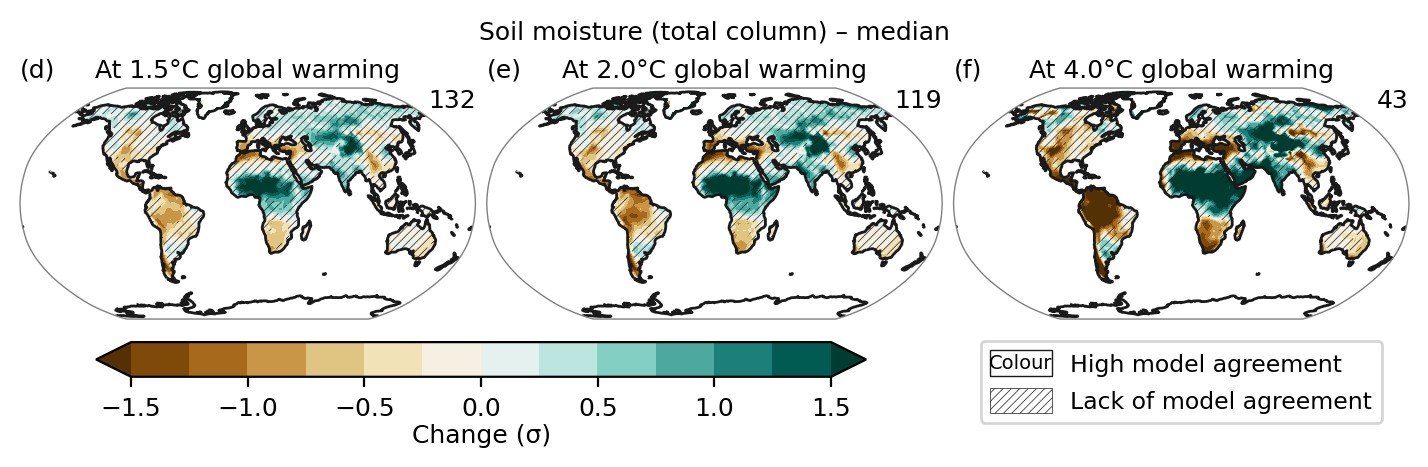

In [7]:
levels = np.arange(-1.5, 1.6, 0.25)

# levels = None
cbar = plot.at_warming_level_one(
    c6_at_warming_mrso_norm,
    "Change (σ)",
    "Soil moisture (total column)",
    levels=levels,
    average="median",
    mask_ocean=True,
    colorbar=True,
    robust=True,
    cmap="BrBG",
    skipna=True,
    hatch_simple=0.8,
    add_legend=True,
    plotfunc="contourf",
)

# cbar.set_ticks(levels)

f = plt.gcf()
axes = f.axes[:3]

axes[0].set_title("(d)", fontsize=9, pad=4, loc="left")
axes[1].set_title("(e)", fontsize=9, pad=4, loc="left")
axes[2].set_title("(f)", fontsize=9, pad=4, loc="left")


fN = conf.cmip6.figure_filename("SM_tot_at_w_norm_simple_hatch", FIGURE_FOLDER)
plt.savefig(fN + ".pdf", dpi=300)
plt.savefig(fN + ".png", dpi=300, transparent=False, facecolor="w")


# data tables
fN = conf.cmip6.figure_filename("SM_tot_at_w_norm_simple_hatch", FIGURE_FOLDER, "data_tables")
dta_ = c6_at_warming_mrso_norm
data_tables.save_simulation_info_raw(fN + "_1.5_md_raw", dta_[0], panel="d")
data_tables.save_simulation_info_raw(fN + "_2.0_md_raw", dta_[1], panel="e")
data_tables.save_simulation_info_raw(fN + "_4.0_md_raw", dta_[2], panel="f")


# save figure data

varn = "SM_total"
figure = "Figure 11.19"
sfd = save_figuredata.SaveFiguredata(
    figure=figure,
    units="std",
    varn=varn,
)

figure = figure.replace(" ", "_")
panels = ["d", "e", "f"]
for i, warming_level in enumerate([1.5, 2.0, 4.0]):

    panel = panels[i]
    fN = conf.cmip6.figure_filename(
        f"{figure}{panel}_cmip6_{varn}_change_at_{warming_level:0.1f}C.nc",
        FIGURE_FOLDER,
        "figure_data",
        add_prefix=False,
    )
    
    da=dta_[i]
    da.attrs["long_name"] = "Total Soil Moisture Content"
    da.attrs["comment"] = "anomaly wrt 1850-1900"


    ds = sfd.map_panel(
        da=da,
        average="median",
        panel=panel,
        warming_level=warming_level,
        hatch_simple=0.8,
    )
    ds.to_netcdf(fN)